In this notebook I am trying to find the relationship between MHC coverage in the initial dataset (the one used to train all available predictors) and entropy with the quality of the prediction. I assumed that MHC coverage more than 500 and entropy more than 30 should suit 

In [11]:
%matplotlib inline

import os
from tqdm import tqdm, tqdm_notebook
from tqdm import trange
from scipy import stats

import pandas as pd
import numpy as np
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_context("notebook")

In [6]:
aa = {'A': 0, 'C': 1, 'D': 2, 'E': 3, 'F': 4, 'G': 5, 'H': 6, 'I': 7,\
      'K': 8, 'L': 9, 'M': 10, 'N': 11, 'P': 12, 'Q': 13, 'R': 14,\
      'S': 15, 'T': 16, 'V': 17, 'W': 18, 'Y': 19}

def count_freq(filepath):
    data = pd.read_csv(filepath, index_col=False, sep=" ")
    binding = data[data.ix[:,2] <= 500]
    freq = np.zeros((20,9))
    for line in binding.ix[:,1]:
        for i, a in enumerate(line):
            try:
                freq[int(aa[a]), i] = freq[aa[a],i]+1
            except KeyError:
                pass
    freq_norm = np.true_divide(freq, 409088)
    freq_norm_r = np.round(freq_norm, 2)
    aa_df = pd.DataFrame(freq_norm_r, index=[i for i in sorted(aa.keys())], columns=np.arange(1,10))
    return aa_df

def plot_freq(aa_df, axes):
#     fig = plt.figure(figsize=(3, 5))
    ax = sns.heatmap(aa_df, ax = axes)
#     plt.show()

def plot_entr(input_df, axes):
    df = pd.DataFrame([stats.entropy(input_df[i], base=2) for i in input_df.columns], columns = ['entropy'])
    df['position'] = input_df.columns
    clrs = ['grey' if x > 3 else 'red' for x in df['entropy']]
#     fig = plt.figure(figsize=(5, 3))
    sns.barplot(data=df, x='position', y='entropy', palette = clrs, ax = axes)

As expected, the two common HLA-B*27 alleles in the European population, B*27:02 (odds ratio (OR)=43; P=1.07 × 10−122) and B*27:05 (OR=62; P<10−321), were the most significantly associated with disease risk (Fig. 1a–b; Tables 1 and 2). Controlling for the effect of the two B*27 alleles, we identified the protective alleles HLA-B*07:02 (OR=0.82; P=5.04 × 10−6) and HLA-B*57:01 (OR=0.75; P=5.13 × 10−4; Table 2)

https://www.nature.com/articles/ncomms8146

In [3]:
# data = pd.read_csv("output/HLA-B27:05_NMP_9mer_proc.txt", index_col=False, sep=" ")
# binding = data[data.ix[:,2] <= 500]
B2705 = count_freq("output/HLA-B27:05_NMP_9mer_proc.txt")
B0702 = count_freq("output/HLA-B07:02_NMP_9mer_proc.txt")

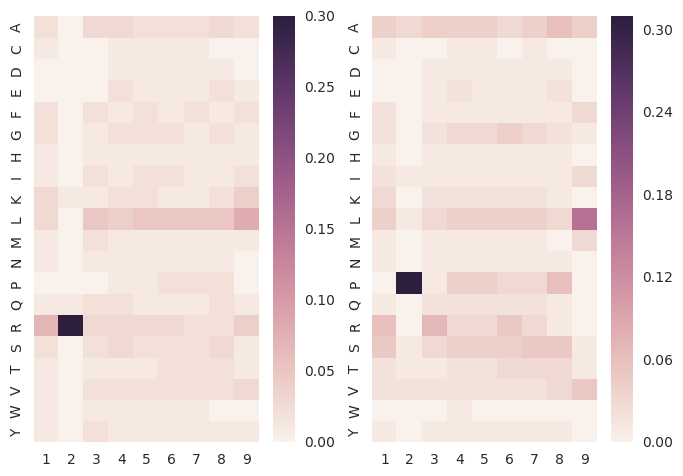

In [4]:
figs, axs = plt.subplots(1,2)

plot_freq(B2705, axs[0])
plot_freq(B0702, axs[1])

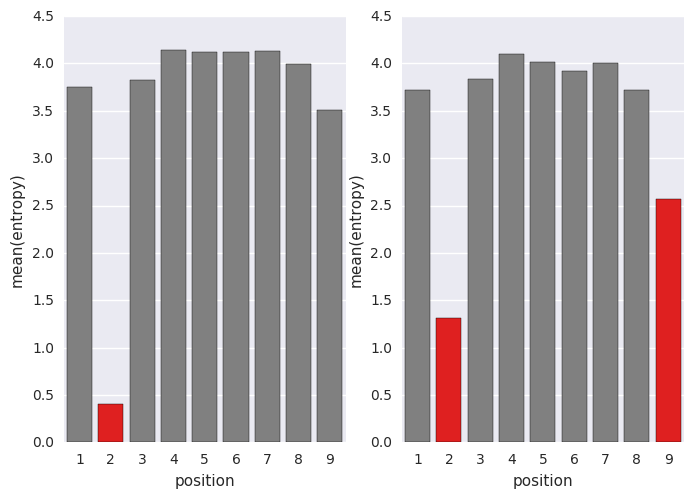

In [5]:
figs, axs = plt.subplots(1,2)

plot_entr(B2705, axs[0])
plot_entr(B0702, axs[1])

In [ ]:
sumentrlist = {}
for filename in tqdm_notebook(os.listdir("output/")):
    if "NMP" in filename:
        entr = 0
        name = filename.replace("_NMP_9mer_proc.txt", "").replace("-", "").replace(":", "")
        freq = count_freq("output/" + filename)
        for col in freq:
            entr += stats.entropy(freq[col], base=2)
        sumentrlist[name] = entr

In [17]:
len(sumentrlist)

82

In [39]:
data = pd.DataFrame.from_dict(sumentrlist, orient="index")
data['name'] = data.index
data[0].value_counts().head(1)

-inf    13
Name: 0, dtype: int64

In [16]:
data = data.replace([np.inf, -np.inf], np.nan).dropna()
data = data.sort_values(by='name')
data.index = range(len(data))
data.head()

,0,name
0,15.726256,HLAA0101
1,32.863292,HLAA0201
2,33.493891,HLAA0202
3,33.347263,HLAA0203
4,33.473073,HLAA0205


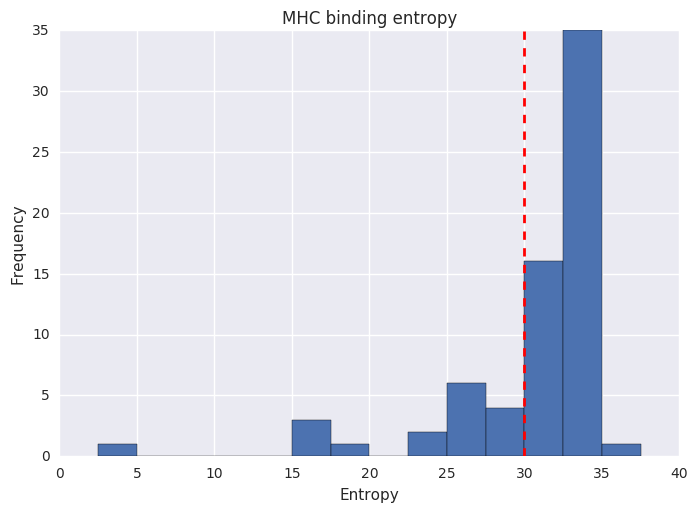

In [26]:
binz = np.arange(0,40,2.5)
plt.hist(data[0], bins=binz)
plt.title("MHC binding entropy")
plt.xlabel("Entropy")
plt.ylabel("Frequency")
thresh = 30
plt.axvline(x=thresh, color='r', linestyle='dashed', linewidth=2)
plt.show()

In [9]:
df = pd.read_csv("data/bdata.csv")
df = df[df['species']=='human']
freq = df.mhc.value_counts()
freq.head()

HLAA0201    11920
HLAA0301     7089
HLAA0203     6302
HLAA1101     6255
HLAA3101     5628
Name: mhc, dtype: int64

In [10]:
len(freq)

118

In [11]:
df = freq[freq.index.isin(data.name)]
df = pd.DataFrame(df)
df['name'] = df.index
df.columns = ['freq', 'name']
df = df.sort_values(by='name')
df.index = range(len(df))
df.head()

,freq,name
0,4558,HLAA0101
1,11920,HLAA0201
2,4155,HLAA0202
3,6302,HLAA0203
4,75,HLAA0205


In [12]:
dfx = pd.concat([data, df], axis=1)
dfx.columns = ["entropy", "allele", "frequency", "delete"]
dfx = dfx.drop('delete', axis=1)
dfx.head()

,entropy,allele,frequency
0,15.726256,HLAA0101,4558.0
1,32.863292,HLAA0201,11920.0
2,33.493891,HLAA0202,4155.0
3,33.347263,HLAA0203,6302.0
4,33.473073,HLAA0205,75.0


/home/vcvetkov/anaconda3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


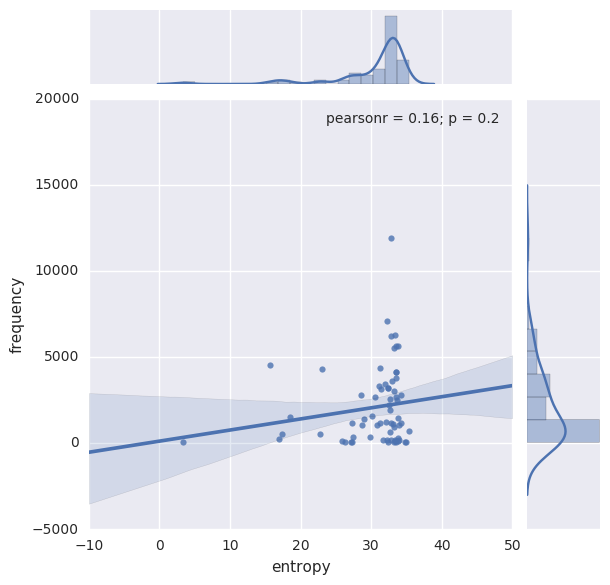

In [13]:
g = sns.jointplot("entropy", "frequency", data=dfx, kind="reg")

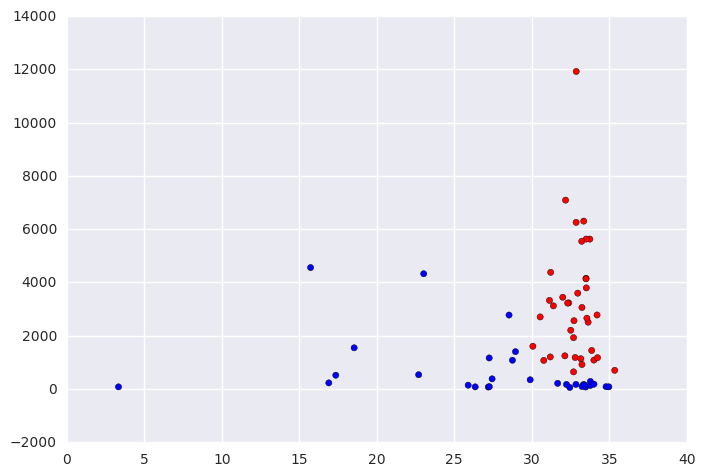

In [14]:
color1 = [1 if dfx.ix[i, 'frequency'] > 500 else 0 for i in dfx.index]
color2 = [1 if dfx.ix[i, 'entropy'] > 30 else 0 for i in dfx.index]
color_i = [k&l for k, l in zip(color1, color2)]
colors = ['r' if i==1 else 'b' for i in color_i]
p = plt.scatter(x = dfx['entropy'], y = dfx['frequency'], c=colors)

In [15]:
len(dfx[(dfx['entropy']>=30)&(dfx['frequency']>=500)]), len(dfx)
""" 
There are 118 alleles in initial dataset. Predictions were made for 82 alleles. These two sets share 69 alleles.
Out of these 69 alleles 37 fit the criteria
"""

' \nThere are 118 alleles in initial dataset. Predictions were made for 82 alleles. These two sets share 69 alleles.\nOut of these 69 alleles 37 fit the criteria\n'

In [16]:
dfx[(dfx['entropy']>=25)&(dfx['entropy']<30)&(dfx['frequency']>=500)]
"""
The entopy from 25 to 30 is a grey area
"""

'\nThe entopy from 25 to 30 is a grey area\n'

In [17]:
A8001 = count_freq("output/HLA-A80:01_NMP_9mer_proc.txt")
B4402 = count_freq("output/HLA-B44:02_NMP_9mer_proc.txt")
B4403 = count_freq("output/HLA-B44:03_NMP_9mer_proc.txt")
B5401 = count_freq("output/HLA-B54:01_NMP_9mer_proc.txt")
"""
There are 4 alleles in grey area, and predictions of 3 of them seem to be of bad quality
"""

'\nThere are 4 alleles in grey area, and predictions of 3 of them seem to be of bad quality\n'

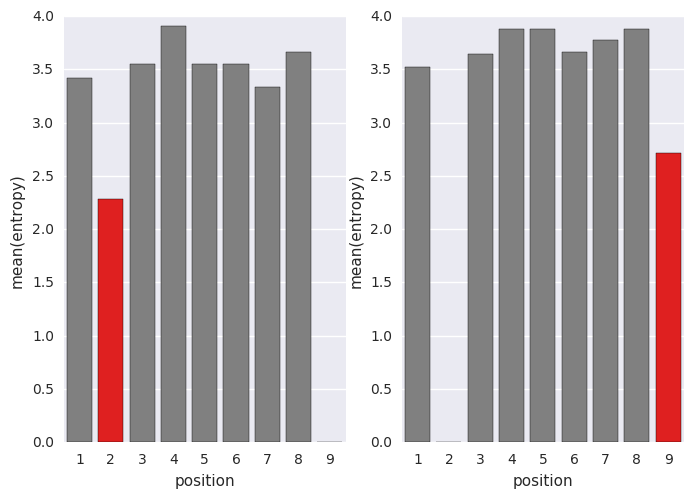

In [18]:
figs, axs = plt.subplots(1,2)

plot_entr(A8001, axs[0])
plot_entr(B4402, axs[1])

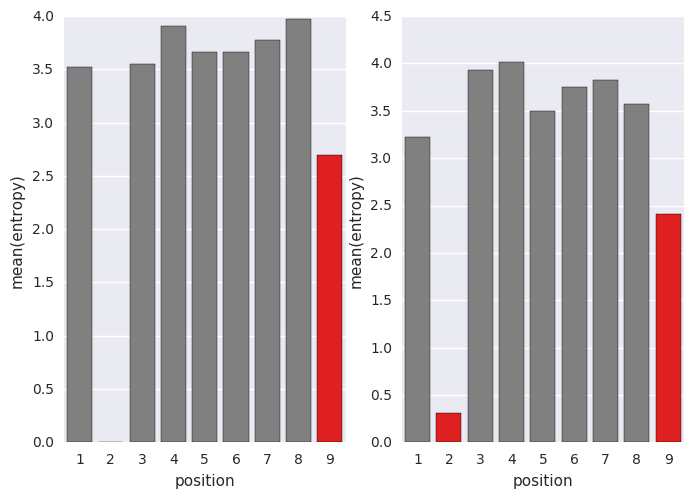

In [19]:
figs, axs = plt.subplots(1,2)

plot_entr(B4403, axs[0])
plot_entr(B5401, axs[1])

In [20]:
"""
5 best predictions by entropy from a white list
"""
dfx[(dfx['entropy']>=30)&(dfx['frequency']>=500)].sort_values(by='entropy').tail(4)

,entropy,allele,frequency
7,34.002410,HLAA0211,1085.0
22,34.206346,HLAA3001,2778.0
17,34.236664,HLAA2403,1176.0
39,35.346933,HLAB1503,701.0


In [21]:
A0211 = count_freq("output/HLA-A02:11_NMP_9mer_proc.txt")
A3001 = count_freq("output/HLA-A30:01_NMP_9mer_proc.txt")
A2403 = count_freq("output/HLA-A24:03_NMP_9mer_proc.txt")
B1503 = count_freq("output/HLA-B15:03_NMP_9mer_proc.txt")

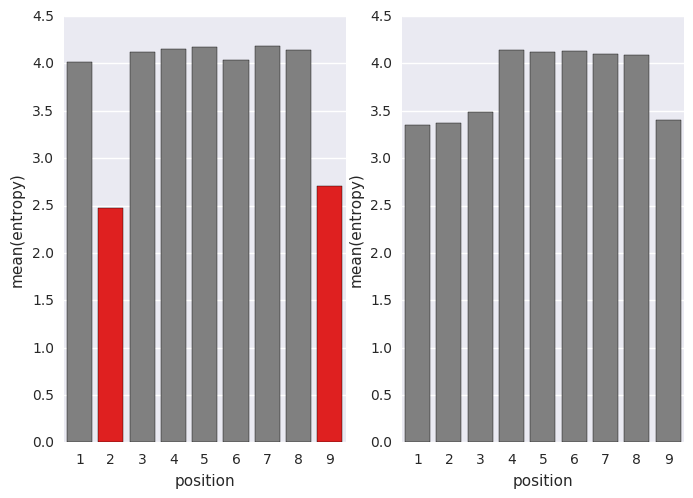

In [22]:
figs, axs = plt.subplots(1,2)

plot_entr(A0211, axs[0])
plot_entr(A3001, axs[1])

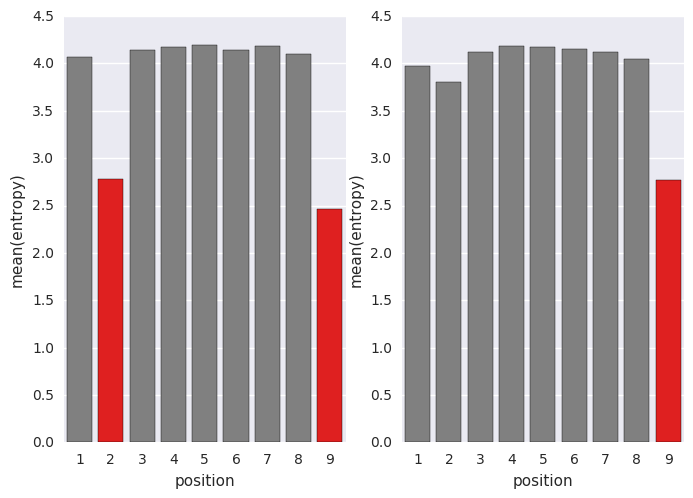

In [23]:
figs, axs = plt.subplots(1,2)

plot_entr(A2403, axs[0])
plot_entr(B1503, axs[1])

In [24]:
"""
5 worst predictions by entropy from a white list
"""
dfx[(dfx['entropy']>=30)&(dfx['frequency']>=500)].sort_values(by='entropy').head(4)

,entropy,allele,frequency
55,30.065070,HLAB4501,1603.0
41,30.536465,HLAB1801,2705.0
49,30.768037,HLAB4001,1074.0
36,31.136996,HLAB0801,3326.0


In [25]:
B4501 = count_freq("output/HLA-B45:01_NMP_9mer_proc.txt")
B1801 = count_freq("output/HLA-B18:01_NMP_9mer_proc.txt")
B4001 = count_freq("output/HLA-B40:01_NMP_9mer_proc.txt")
B0801 = count_freq("output/HLA-B08:01_NMP_9mer_proc.txt")

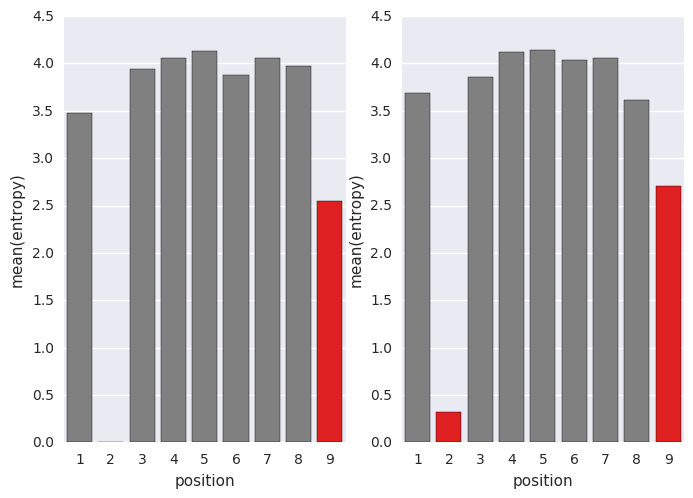

In [26]:
figs, axs = plt.subplots(1,2)

plot_entr(B4501, axs[0])
plot_entr(B1801, axs[1])

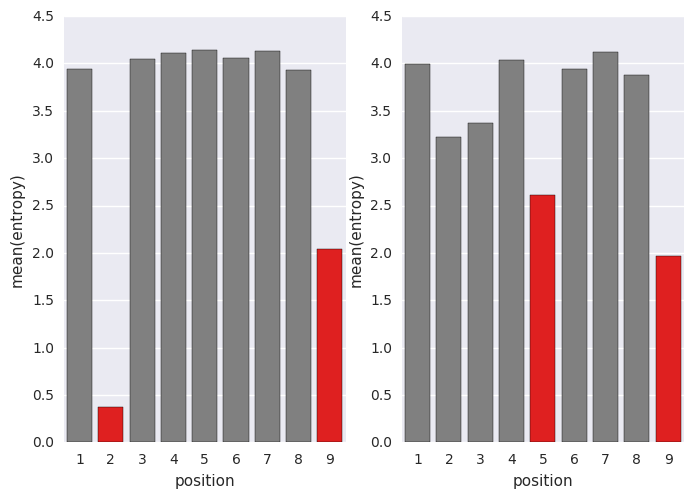

In [27]:
figs, axs = plt.subplots(1,2)

plot_entr(B4001, axs[0])
plot_entr(B0801, axs[1])

/home/vcvetkov/anaconda3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


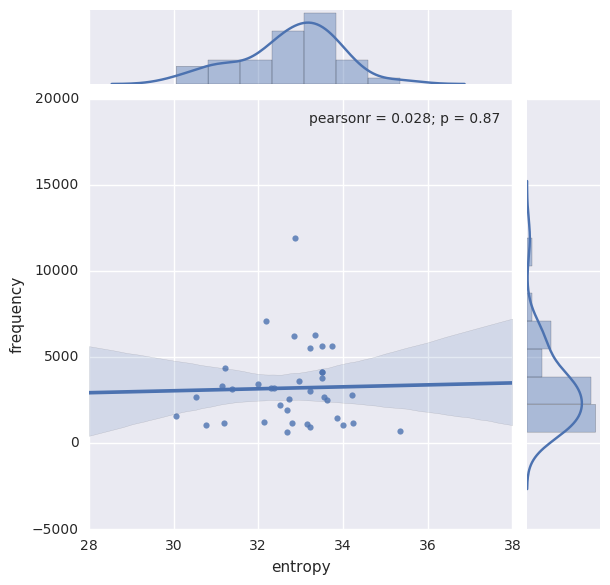

In [28]:
g1 = sns.jointplot("entropy", "frequency", data=dfx[(dfx['entropy']>=30)&(dfx['frequency']>=500)], kind="reg")

In [30]:
data[data[0]>=30].name

1     HLAA0201
2     HLAA0202
3     HLAA0203
4     HLAA0205
5     HLAA0206
7     HLAA0211
8     HLAA0212
9     HLAA0216
11    HLAA0219
12    HLAA0250
13    HLAA0301
14    HLAA1101
15    HLAA2301
16    HLAA2402
17    HLAA2403
19    HLAA2602
21    HLAA2902
22    HLAA3001
23    HLAA3002
24    HLAA3101
25    HLAA3201
26    HLAA3207
28    HLAA3301
30    HLAA6801
31    HLAA6802
32    HLAA6823
33    HLAA6901
35    HLAB0702
36    HLAB0801
37    HLAB1501
38    HLAB1502
39    HLAB1503
40    HLAB1517
41    HLAB1801
42    HLAB2705
43    HLAB2709
44    HLAB2720
45    HLAB3501
48    HLAB3901
49    HLAB4001
50    HLAB4002
51    HLAB4013
52    HLAB4201
55    HLAB4501
56    HLAB5301
58    HLAB5701
59    HLAB5801
60    HLAC0303
64    HLAC0702
66    HLAC1203
67    HLAC1402
68    HLAC1502
Name: name, dtype: object

Here I'm going to find a relationship between entropy and number or proportion of binders

In [ ]:
bin_data = {}
for filename in tqdm_notebook(os.listdir("output/")):
    if "NMP" in filename:
        name = filename.replace("_NMP_9mer_proc.txt", "").replace("-", "").replace(":", "")
        data = pd.read_csv("output/" + filename, index_col=False, sep=" ")
        binding = data[data.ix[:,2] <= 500]
        bin_data[name] = binding.size

In [38]:
df = pd.DataFrame([bin_data])
df = df.transpose()
df.columns = [1]
df.head()

,1
HLAA0101,97926
HLAA0201,1011321
HLAA0202,1597239
HLAA0203,1546611
HLAA0205,1354293


In [43]:
data = data.sort_values(by='name')
data.head()

,0,name
HLAA0101,15.726256,HLAA0101
HLAA0201,32.863292,HLAA0201
HLAA0202,33.493891,HLAA0202
HLAA0203,33.347263,HLAA0203
HLAA0205,33.473073,HLAA0205


In [44]:
df[0] = data[0]
df.head()

,1,0
HLAA0101,97926,15.726256
HLAA0201,1011321,32.863292
HLAA0202,1597239,33.493891
HLAA0203,1546611,33.347263
HLAA0205,1354293,33.473073


In [47]:
df[2] = df[1].apply(lambda x: x/10379347)
df.columns = ['count', 'entropy', 'proportion']
df.head()

,count,entropy,proportion
HLAA0101,97926,15.726256,0.009435
HLAA0201,1011321,32.863292,0.097436
HLAA0202,1597239,33.493891,0.153886
HLAA0203,1546611,33.347263,0.149009
HLAA0205,1354293,33.473073,0.130480


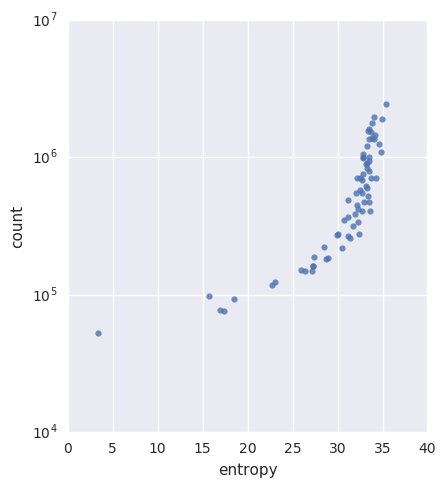

In [58]:
ax1 = sns.lmplot(data = df, x = "entropy", y = "count")
ax1.set(yscale="log")

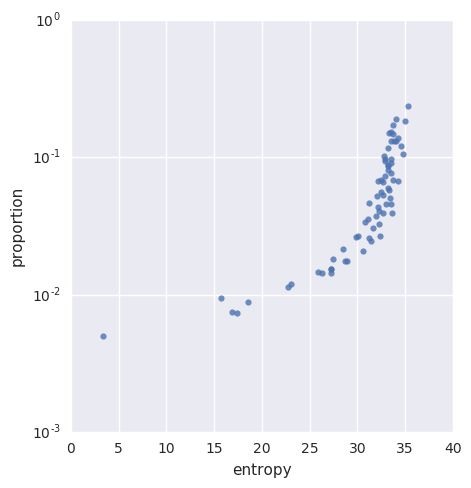

In [60]:
ax2 = sns.lmplot(data = df, x = "entropy", y = "proportion")
ax2.set(yscale="log")